# NBA Player Performance Analysis

This notebook examines NBA player statistics to identify patterns and relationships that could be useful for predicting player performance. We analyze regular season vs playoff performance and investigate relationships between playing time and production.

## Potential Applications

1. **Playoff Performance Prediction**: Identify which players maintain or improve their efficiency in the playoffs
2. **Minutes to Production Optimize**: Help teams optimize player minutes for maximum scoring efficiency
3. **Position Based Performance Analysis**: Understand how different positions score

In [54]:
# necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from get_data import fetch_bbr_player_avg_stats, fetch_bbr_playoffs_stats

# Set the style for our visualizations
plt.style.use("fivethirtyeight")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]

## Data Preparation

First, we need to fetch and preprocess our data using out data cleaner.

In [26]:
def custom_preprocess(df):
    """Custom preprocessing function that safely handles numeric conversions"""
    df = df.copy()
    
    if "Awards" in df.columns:
        df = df.drop(columns=["Awards"])
    
    if "Rk" in df.columns:
        df = df.drop(columns=["Rk"])
    
    df.columns = [
        col.strip().lower().replace(" ", "_").replace("%", "pct") for col in df.columns
    ]
    
    pct_cols = ["fgpct", "3pct", "2pct", "efgpct", "ftpct"]
    for col in pct_cols:
        if col in df.columns:
            if df[col].dtype == "object":
                df[col] = df[col].str.strip("%")
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
                
    for col in df.columns:
        if col not in pct_cols and col not in ["player", "tm", "pos"]:
            if df[col].dtype == "object":
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
    
    return df

In [47]:
# Fetch data for last 3 seasons
seasons = ["2021-22", "2022-23", "2023-24"]
all_regular_data = []
all_playoff_data = []

print("Fetching data for multiple seasons...")
for season in seasons:
    print(f"Fetching {season} regular season data...")
    regular_season = fetch_bbr_player_avg_stats(season)
    regular_season['season'] = season
    all_regular_data.append(custom_preprocess(regular_season))
    
    print(f"Fetching {season} playoff data...")
    playoffs = fetch_bbr_playoffs_stats(season)
    playoffs['season'] = season
    all_playoff_data.append(custom_preprocess(playoffs))

# Combine all seasons
regular_stats = pd.concat(all_regular_data)
playoff_stats = pd.concat(all_playoff_data)

print(f"Combined regular season data shape: {regular_stats.shape}")
print(f"Combined playoff data shape: {playoff_stats.shape}")

Fetching data for multiple seasons...
Fetching 2021-22 regular season data...


/Users/danielrodriguez/Documents/CS418/Project/untitled folder/group-project-data-denizens/analysis/EDA-drodr31/get_data.py:40: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Fetching 2021-22 playoff data...


/Users/danielrodriguez/Documents/CS418/Project/untitled folder/group-project-data-denizens/analysis/EDA-drodr31/get_data.py:56: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Fetching 2022-23 regular season data...


/Users/danielrodriguez/Documents/CS418/Project/untitled folder/group-project-data-denizens/analysis/EDA-drodr31/get_data.py:40: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Fetching 2022-23 playoff data...


/Users/danielrodriguez/Documents/CS418/Project/untitled folder/group-project-data-denizens/analysis/EDA-drodr31/get_data.py:56: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Fetching 2023-24 regular season data...


/Users/danielrodriguez/Documents/CS418/Project/untitled folder/group-project-data-denizens/analysis/EDA-drodr31/get_data.py:40: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Fetching 2023-24 playoff data...
Combined regular season data shape: (2229, 30)
Combined playoff data shape: (648, 30)


/Users/danielrodriguez/Documents/CS418/Project/untitled folder/group-project-data-denizens/analysis/EDA-drodr31/get_data.py:56: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



## Dataset Overview

1. Sample Size: Contains data for 735-736 players
2. Age Range: Players range from 19 to 39 years old (mean: 26.16 years)
3. Playing Time: Highly variable with players averaging between 0.5 to 37.8 minutes per game

**Playing Time Distribution**
1. Wide spread in games played (1-84 games)
2. Only about half of players start regularly (median games started: 5)
3. Significant minutes difference (standard deviation: 9.74 minutes)

**Scoring Patterns**
1. Average scoring: 8.02 points per game
2. High variance in scoring (SD: 6.48 points)
3. Top scorers reaching 34.7 points per game
4. 75% of players score below 11.05 points per game

**Shooting Efficiency**
1. Average FG%: 45% (fairly consistent with SD of 11%)
2 . Free throw shooting averages 75%
3. Three-point attempts (2.58 average) about 40% of total field goal attempts
   
**Potential Data Issues**
1. Problem in the "team" column (all values are 0)

In [28]:
# Display data with describe
regular_stats.describe().round(2)

,age,team,g,gs,mp,fg,fga,fgpct,3p,3pa,...,ftpct,orb,drb,trb,ast,stl,blk,tov,pf,pts
count,735.00,736.0,735.00,735.00,735.00,735.00,735.00,728.00,735.00,735.00,...,677.00,735.00,735.00,735.00,735.00,735.00,735.00,735.00,735.00,735.00
mean,26.16,0.0,40.88,18.44,18.26,2.97,6.42,0.45,0.91,2.58,...,0.75,0.82,2.42,3.24,1.93,0.59,0.38,0.94,1.46,8.02
std,4.37,0.0,25.58,25.02,9.74,2.36,4.78,0.11,0.85,2.17,...,0.16,0.73,1.74,2.32,1.80,0.39,0.40,0.76,0.78,6.48
min,19.00,0.0,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,23.00,0.0,17.00,0.00,10.60,1.30,3.00,0.40,0.20,0.90,...,0.69,0.30,1.10,1.60,0.70,0.30,0.10,0.40,0.90,3.40
50%,25.00,0.0,41.00,5.00,17.20,2.30,5.00,0.45,0.70,2.10,...,0.78,0.60,2.10,2.80,1.30,0.50,0.30,0.70,1.40,6.10
75%,29.00,0.0,64.50,29.00,26.45,4.15,8.70,0.50,1.40,3.70,...,0.84,1.10,3.35,4.30,2.60,0.80,0.50,1.30,2.00,11.05
max,39.00,0.0,84.00,82.00,37.80,11.50,23.60,0.80,4.80,11.80,...,1.00,4.60,10.10,13.70,10.90,2.10,3.60,4.40,3.60,34.70


Player position distribution:
pos
SG    160
SF    157
PF    153
PG    146
C     119
Name: count, dtype: int64


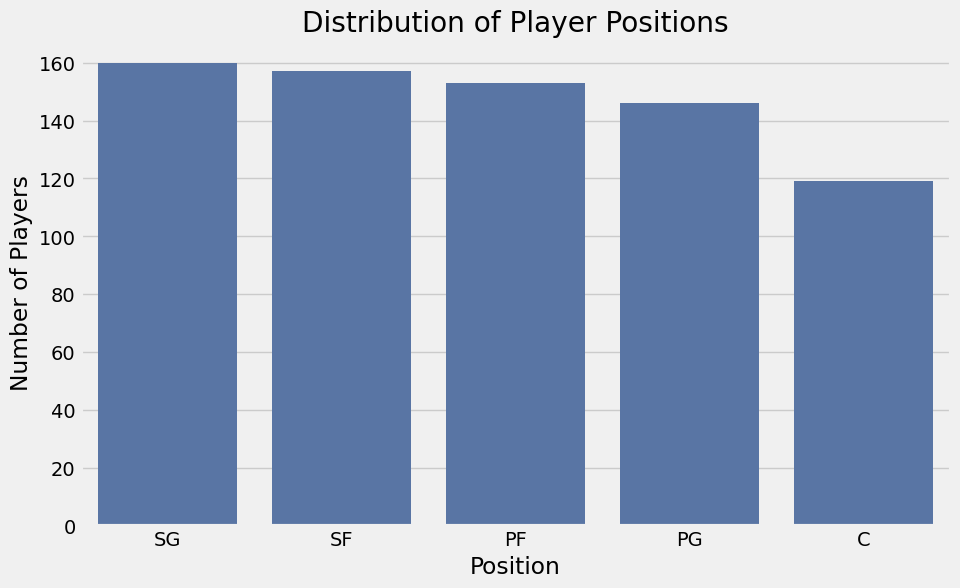

In [29]:
# player position distribution
if "pos" in regular_stats.columns:
    position_counts = regular_stats["pos"].value_counts()
    print("Player position distribution:")
    print(position_counts)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=position_counts.index, y=position_counts.values)
    plt.title("Distribution of Player Positions")
    plt.ylabel("Number of Players")
    plt.xlabel("Position")
    plt.show()

## Regular Season vs. Playoff Performance

### Hypothesis: Players shoot differently in playoffs compared to regular season

It's crucial to know which players maintain or do better in high pressure playoff situations. We can compare field goal percentages between regular season and playoffs to find any patterns.

In [49]:
if "player" in regular_stats.columns and "player" in playoff_stats.columns:
    merged_data = pd.merge(
        regular_stats, playoff_stats, on=["player", "season"], suffixes=("_regular", "_playoff")
    )
    
    print(f"Number of player-seasons in both regular season and playoffs: {len(merged_data)}")
    
    min_mp = 15  # Minimum minutes per game
    filtered_data = merged_data[
        (merged_data["mp_regular"] >= min_mp) & (merged_data["mp_playoff"] >= min_mp)
    ]
    
    fg_diff = filtered_data["fgpct_playoff"] - filtered_data["fgpct_regular"]
    avg_diff = fg_diff.mean()
    print(f"Average difference in FG% (Playoff - Regular): {avg_diff:.4f}")
    
    # Count how many players improved
    improved = (fg_diff > 0).sum()
    declined = (fg_diff < 0).sum()
    same = (fg_diff == 0).sum()
    print(f"Players with improved FG% in playoffs: {improved} ({improved/len(fg_diff):.1%})")
    print(f"Players with declined FG% in playoffs: {declined} ({declined/len(fg_diff):.1%})")
    print(f"Players with unchanged FG% in playoffs: {same} ({same/len(fg_diff):.1%})")

Number of player-seasons in both regular season and playoffs: 2304
Average difference in FG% (Playoff - Regular): -0.0180
Players with improved FG% in playoffs: 457 (35.7%)
Players with declined FG% in playoffs: 815 (63.6%)
Players with unchanged FG% in playoffs: 9 (0.7%)


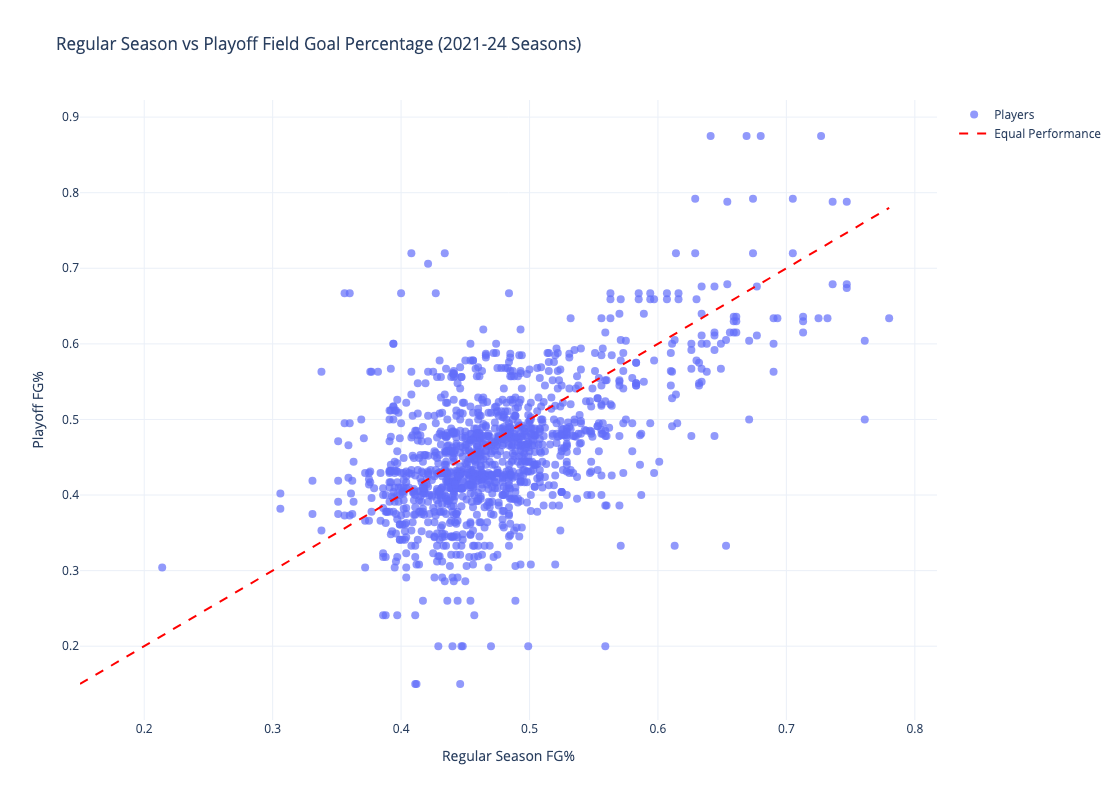

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=filtered_data["fgpct_regular"],
    y=filtered_data["fgpct_playoff"],
    mode='markers',
    marker=dict(
        size=8,
        opacity=0.7,
    ),
    hovertemplate="<b>Player:</b> %{text}<br>" +
                  "Season: %{customdata}<br>" +
                  "Regular Season FG%: %{x:.3f}<br>" +
                  "Playoff FG%: %{y:.3f}<br>" +
                  "<extra></extra>",
    text=filtered_data["player"],
    customdata=filtered_data["season"],
    name='Players'
))

fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    name='Equal Performance',
    line=dict(
        dash='dash',
        color='red'
    )
))

fig.update_layout(
    title="Regular Season vs Playoff Field Goal Percentage (2021-24 Seasons)",
    xaxis_title="Regular Season FG%",
    yaxis_title="Playoff FG%",
    width=1000,
    height=800,
    showlegend=True,
    template='plotly_white',
    hovermode='closest',
    autosize=True
)


fig.show()

## Minutes vs. Scoring Production

### Hypothesis: Playing time correlates strongly with scoring output, but the relationship varies by position

Understanding the relationship between minutes played and scoring can help teams optimize player rotations and load management strategies.

/opt/anaconda3/envs/cs418env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 135 (\x87) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/cs418env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 141 (\x8d) missing from font(s) DejaVu Sans.



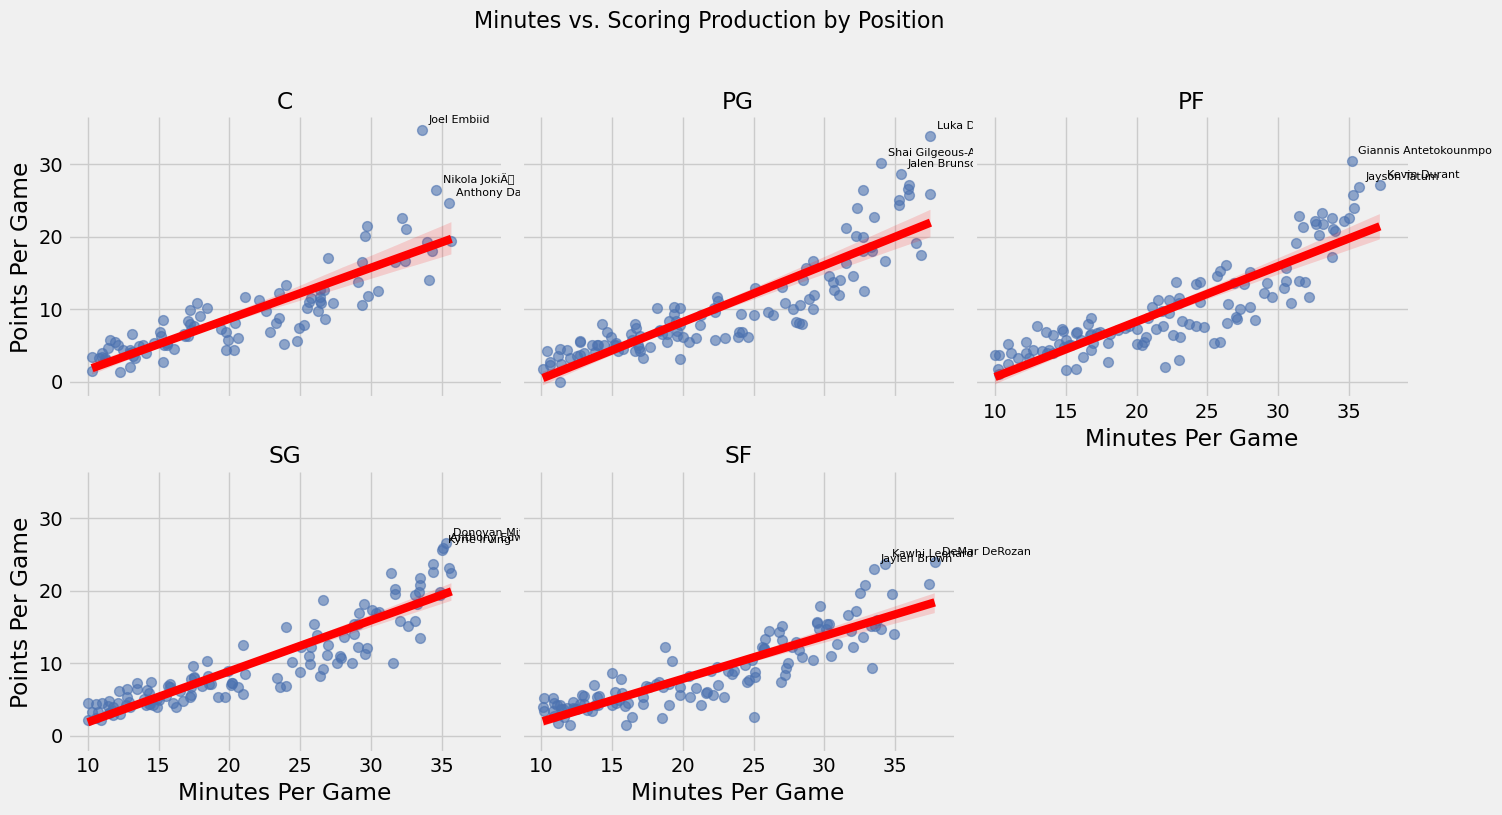

Overall correlation between Minutes and Points: 0.8870

Position-specific correlations:
PG: 0.8759
SG: 0.9216
SF: 0.9018
PF: 0.8787
C: 0.8716


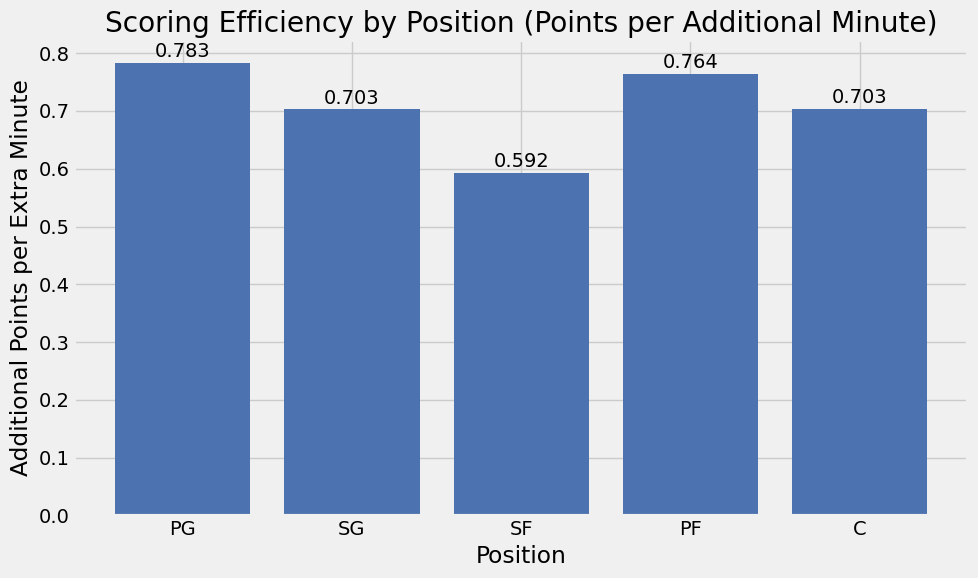

In [32]:
# facet grid to show minutes vs. points by position
if "pos" in regular_stats.columns:
    # Filter out players with very few minutes
    min_mp = 10
    filtered_data = regular_stats[regular_stats["mp"] >= min_mp].copy()
    valid_positions = ["PG", "SG", "SF", "PF", "C"]
    filtered_data = filtered_data[filtered_data["pos"].isin(valid_positions)]
    
    g = sns.FacetGrid(filtered_data, col="pos", col_wrap=3, height=4, aspect=1.2)
    g.map_dataframe(sns.regplot, x="mp", y="pts", scatter_kws={"alpha": 0.6, "s": 50}, line_kws={"color": "red"})
    g.set_axis_labels("Minutes Per Game", "Points Per Game")
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle("Minutes vs. Scoring Production by Position", y=1.02, fontsize=16)
    g.tight_layout()
    
    # top scorers in each position
    for position, ax in g.axes_dict.items():
        pos_data = filtered_data[filtered_data["pos"] == position]
        top_scorers = pos_data.sort_values("pts", ascending=False).head(3)
        
        for _, player in top_scorers.iterrows():
            ax.annotate(
                player["player"],
                (player["mp"], player["pts"]),
                fontsize=8,
                xytext=(5, 5),
                textcoords="offset points"
            )
    
    plt.show()
    

    overall_corr = regular_stats["mp"].corr(regular_stats["pts"])
    print(f"Overall correlation between Minutes and Points: {overall_corr:.4f}")
    
    # Calculate position correlations
    print("\nPosition-specific correlations:")
    for pos in valid_positions:
        pos_data = regular_stats[regular_stats["pos"] == pos]
        if len(pos_data) > 5: # good data
            pos_corr = pos_data["mp"].corr(pos_data["pts"])
            print(f"{pos}: {pos_corr:.4f}")
            
    plt.figure(figsize=(10, 6))
    position_slopes = []
    position_names = []
    
    for pos in valid_positions:
        pos_data = filtered_data[filtered_data["pos"] == pos]
        if len(pos_data) > 5:
            slope = np.polyfit(pos_data["mp"], pos_data["pts"], 1)[0]
            position_slopes.append(slope)
            position_names.append(pos)
    
    bars = plt.bar(position_names, position_slopes)
    for i, pos in enumerate(position_names):
        plt.text(i, position_slopes[i] + 0.01, f"{position_slopes[i]:.3f}", ha='center')
        
    plt.title("Scoring Efficiency by Position (Points per Additional Minute)")
    plt.ylabel("Additional Points per Extra Minute")
    plt.xlabel("Position")
    plt.tight_layout()
    plt.show()

## Scoring Efficiency Analysis

Examine scoring efficiency.

/var/folders/03/z6dn67t97x12ypp0smxg86800000gn/T/ipykernel_10251/637457047.py:52: UserWarning:

Glyph 141 (\x8d) missing from font(s) DejaVu Sans.

/var/folders/03/z6dn67t97x12ypp0smxg86800000gn/T/ipykernel_10251/637457047.py:52: UserWarning:

Glyph 135 (\x87) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/cs418env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 141 (\x8d) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/cs418env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 135 (\x87) missing from font(s) DejaVu Sans.



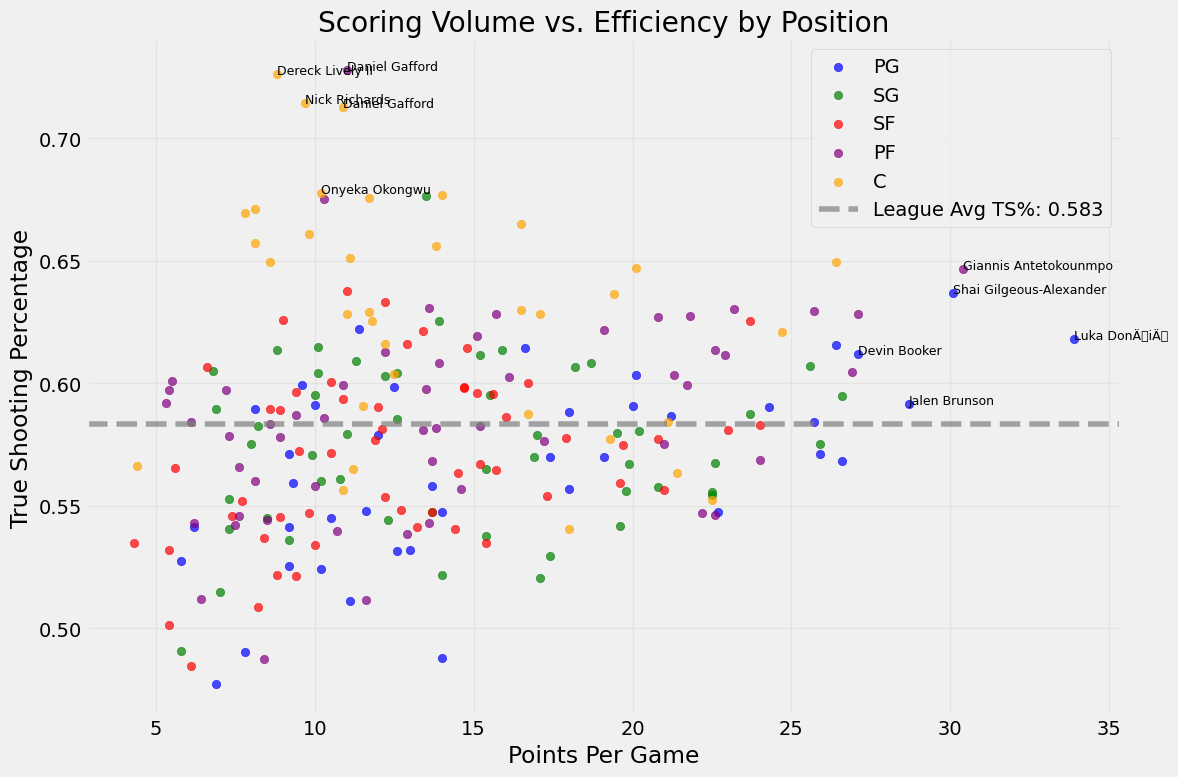

Correlation between Points and True Shooting %: 0.1912


In [33]:
if "ts_pct" not in regular_stats.columns:
    # True Shooting formula: PTS / (2 * (FGA + 0.44 * FTA))
    regular_stats["ts_pct"] = regular_stats["pts"] / (2 * (regular_stats["fga"] + 0.44 * regular_stats["fta"]))
    regular_stats["ts_pct"] = regular_stats["ts_pct"].replace([np.inf, -np.inf, np.nan], 0)
#Filter
min_minutes = 20
min_games = 40
filtered_regular = regular_stats[
    (regular_stats["mp"] >= min_minutes) & (regular_stats["g"] >= min_games)
]

plt.figure(figsize=(12, 8))
pos_colors = {
    "PG": "blue",
    "SG": "green",
    "SF": "red",
    "PF": "purple",
    "C": "orange",
}

for pos in pos_colors:
    pos_data = filtered_regular[filtered_regular["pos"] == pos]
    if not pos_data.empty:
        plt.scatter(
            pos_data["pts"],
            pos_data["ts_pct"],
            c=pos_colors.get(pos, "gray"),
            label=pos,
            alpha=0.7,
        )

notable_players = pd.concat([
    filtered_regular.sort_values("pts", ascending=False).head(5),  # Top scorers
    filtered_regular.sort_values("ts_pct", ascending=False).head(5)  # Most efficient
]).drop_duplicates()

for i, row in notable_players.iterrows():
    plt.annotate(
        row["player"],
        (row["pts"], row["ts_pct"]),
        fontsize=9
    )

avg_ts = filtered_regular["ts_pct"].mean()
plt.axhline(y=avg_ts, color='gray', linestyle='--', alpha=0.7, label=f'League Avg TS%: {avg_ts:.3f}')

plt.xlabel("Points Per Game")
plt.ylabel("True Shooting Percentage")
plt.title("Scoring Volume vs. Efficiency by Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = filtered_regular["pts"].corr(filtered_regular["ts_pct"])
print(f"Correlation between Points and True Shooting %: {corr:.4f}")

## Conclusion

This analysis has explored several key aspects of NBA player performance data:

1. **Regular Season vs. Playoff Performance**: This found that most players experience a decline in shooting efficiency during the playoffs. This finding can help teams prioritize players who maintain their efficiency in the playoffs.

2. **Minutes to Production Relationship**: We found a correlation between minutes played and scoring production, with variations by position. This can guide management strategies and playing time.

3. **Scoring Volume vs. Efficiency**: By examining the relationship between scoring volume and efficiency, we can identify both efficient scorers and breakout players.

### Potential Machine Learning


1. **Playoff Performance Predictor**: A model to forecast how a player's efficiency will change in the playoffs based on regular season performance, experience, and other factors.

2. **Minutes Optimization Model**: A model that recommends optimal minutes distribution across a team's roster to maximize offensive output while managing player fatigue.


3. **Trade Value Calculator**: A model that evaluates potential trades by finding how players might perform in new team contexts based on their efficiency metrics.
